<a href="https://colab.research.google.com/github/faizanhemotra/CE888/blob/main/Project/Irony_BERTweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data Set

In [ ]:
import numpy as np
import re
import requests

In [ ]:
def shape_data(feature, label):
    '''Returns number of rows for feature and label'''
    return len(feature.splitlines()), len(label.splitlines())

In [ ]:
irony_train_url = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/irony/train_text.txt'
irony_train = requests.get(irony_train_url)
irony_train_labels_url = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/irony/train_labels.txt'
irony_train_labels = requests.get(irony_train_labels_url)
print('Irony Training, Label')
shape_data(irony_train.text, irony_train_labels.text)

Irony Training, Label


(2862, 2862)

In [ ]:
irony_val_url = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/irony/val_text.txt'
irony_val = requests.get(irony_val_url)
irony_val_labels_url = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/irony/val_labels.txt'
irony_val_labels = requests.get(irony_val_labels_url)
print('Irony Validation, Label')
shape_data(irony_val.text, irony_val_labels.text)

Irony Validation, Label


(955, 955)

In [ ]:
irony_test_url = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/irony/test_text.txt'
irony_test = requests.get(irony_test_url)
irony_test_labels_url = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/irony/test_labels.txt'
irony_test_labels = requests.get(irony_test_labels_url)
print('Irony Test, Label')
shape_data(irony_test.text, irony_test_labels.text)

Irony Test, Label


(784, 784)

##Labels

In [ ]:
irony_train_distr = list()
for label in irony_train_labels.text.splitlines():
    irony_train_distr.append(int(label))

irony_val_distr = list()
for label in irony_val_labels.text.splitlines():
    irony_val_distr.append(int(label))

irony_test_distr = list()
for label in irony_test_labels.text.splitlines():
    irony_test_distr.append(int(label))

In [ ]:
labels = list(set(irony_train_distr))
print(labels)

[0, 1]


In [ ]:
def linkremover(text):
    '''Removes t.co and instagram.com links from the data'''
    tco = r'https?://t.co/[\w]{10}'
    insta = r'https?://(www.)?instagram.com/p/[-\w]{11}/?'
    if (re.findall(tco + '|' + insta, text) != []):
        final = re.sub(tco + '|' + insta, '', text)
        return final
    else:
        print('No links')
    return text

In [ ]:
irony_tr = linkremover(irony_train.text)
irony_v = linkremover(irony_val.text)
irony_te = linkremover(irony_test.text)

In [ ]:
import os
import torch
hftransformers = os.path.exists('/content/transformers')
if hftransformers:
  print('transformers already downloaded ')
else:
  !git clone https://github.com/huggingface/transformers.git

transformers already downloaded 


In [ ]:
cd transformers

/content/transformers


In [ ]:
if hftransformers:
  print('transformers already downloaded ')
else:
  !pip3 install --upgrade .

transformers already downloaded 


In [ ]:
import importlib
emoji = importlib.util.find_spec("emoji")
found = emoji is not None
if found:
  print('emoji package already exists')
else:
  !pip3 install emoji

emoji package already exists


## Tokenizing

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
torch.manual_seed(2)
np.random.seed(2)

In [ ]:
train_encodings = tokenizer(irony_tr.splitlines(), truncation=True, padding=True)
valid_encodings = tokenizer(irony_v.splitlines(), truncation=True, padding=True)
test_encodings = tokenizer(irony_te.splitlines(), truncation=True, padding=True)

In [ ]:
class Irony(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_dataset = Irony(train_encodings, irony_train_distr)
valid_dataset = Irony(valid_encodings, irony_val_distr)
test_dataset = Irony(test_encodings, irony_test_distr)

##Training

In [ ]:
from sklearn.metrics import f1_score
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds)
    return {
        'f1': f1
    }

model = RobertaForSequenceClassification.from_pretrained('vinai/bertweet-base', cache_dir='cache/', num_labels=len(labels))
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total # of training epochs
    per_device_train_batch_size=10,  # batch size per device during training
    per_device_eval_batch_size=10,   # batch size for evaluation
    evaluation_strategy = "epoch",
    disable_tqdm=False,
    load_best_model_at_end=True,
    save_total_limit=7,
    learning_rate=1e-5,
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_steps=8,
    logging_dir='./logs',            # directory for storing logs
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics
)

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
if device == 'cuda':
  !nvidia-smi

Fri Apr 16 15:29:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    31W /  70W |   1622MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.662200,0.675294,0.655008
2,0.500100,0.509580,0.759259
3,0.398400,0.494457,0.770199
4,0.198700,0.579118,0.769723
5,0.160900,0.665622,0.768737


TrainOutput(global_step=1435, training_loss=0.45110523324810253, metrics={'train_runtime': 535.5341, 'train_samples_per_second': 2.68, 'total_flos': 1482578343060480.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 2237661184, 'init_mem_gpu_alloc_delta': 540129280, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 523927552, 'train_mem_gpu_alloc_delta': 2182801920, 'train_mem_cpu_peaked_delta': 0, 'train_mem_gpu_peaked_delta': 605465088})

In [ ]:
torch.save(model.state_dict(), 'model_RoB_irony.pth')

## Evaluations

In [ ]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
def plot_confusion_matrix(conf_mat, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    conf_mat: confusion matrix
    classes: names of classes to be annotated
    normalize: [True/False] whether to normalise by column
    """
    if normalize:
        conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(conf_mat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
        t = "(%.2f)" % (conf_mat[i, j])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Validation Dataset

In [ ]:
val_pred = trainer.predict(valid_dataset)
val_pred.metrics

{'test_f1': 0.7701993704092339,
 'test_loss': 0.49445703625679016,
 'test_mem_cpu_alloc_delta': 0,
 'test_mem_cpu_peaked_delta': 0,
 'test_mem_gpu_alloc_delta': 0,
 'test_mem_gpu_peaked_delta': 27526144,
 'test_runtime': 3.1508,
 'test_samples_per_second': 303.094}

In [ ]:
validation_pred = []
for i in range(len(val_pred.predictions)):
  validation_pred.append(np.argmax(val_pred.predictions[i]))

Normalized confusion matrix


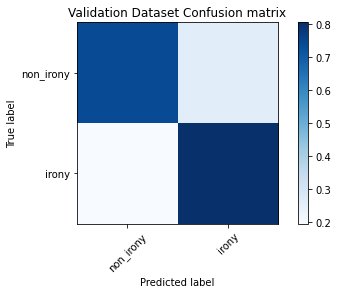

In [ ]:
cnf_matrix = confusion_matrix(irony_val_distr, validation_pred)
plot_confusion_matrix(cnf_matrix, classes=['non_irony', 'irony'], normalize=True,
                      title='Validation Dataset Confusion matrix')

In [ ]:
print(classification_report(irony_val_distr, validation_pred, digits=5))

              precision    recall  f1-score   support

           0    0.80568   0.73948   0.77116       499
           1    0.73843   0.80482   0.77020       456

    accuracy                        0.77068       955
   macro avg    0.77205   0.77215   0.77068       955
weighted avg    0.77357   0.77068   0.77070       955



### Test Dataset

In [ ]:
te_pred = trainer.predict(test_dataset)
te_pred.metrics

{'test_f1': 0.8070175438596491,
 'test_loss': 0.4339737296104431,
 'test_mem_cpu_alloc_delta': 0,
 'test_mem_cpu_peaked_delta': 0,
 'test_mem_gpu_alloc_delta': 0,
 'test_mem_gpu_peaked_delta': 32536576,
 'test_runtime': 2.7393,
 'test_samples_per_second': 286.207}

In [ ]:
test_pred = []
for i in range(len(te_pred.predictions)):
  test_pred.append(np.argmax(te_pred.predictions[i]))

Normalized confusion matrix


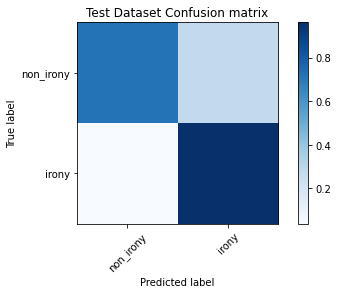

In [ ]:
cnf_matrix = confusion_matrix(irony_test_distr, test_pred)
plot_confusion_matrix(cnf_matrix, classes=['non_irony', 'irony'], normalize=True,
                      title='Test Dataset Confusion matrix')

In [ ]:
print(classification_report(irony_test_distr, test_pred, digits=5))

              precision    recall  f1-score   support

           0    0.96610   0.72304   0.82709       473
           1    0.69535   0.96141   0.80702       311

    accuracy                        0.81760       784
   macro avg    0.83073   0.84223   0.81705       784
weighted avg    0.85870   0.81760   0.81913       784



## Saving to Google Drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !cp -r ./model_irony.pth /content/drive/MyDrive